In this kernel we will go through a sentiment analysis on imdb dataset using LSTM.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
# from google.colab import drive

# # This will prompt you to click on a link to generate an authorization code.
# drive.mount('/content/drive')

In [4]:
ls 

LSTM.ipynb  test.ft.txt  train.ft.txt  working/


In [5]:
def load_fasttext_data(filename):
    with open(filename, 'r', encoding="utf-8") as file:
        lines = file.read().splitlines()

    labels = []
    texts = []
    for line in lines:
        label, text = line.split(" ", 1)
        labels.append(label.replace('label', ''))
        texts.append(text)
    return labels, texts

In [6]:
file_path = '/home/cc/home/SEWAI_pj2/'
#load datasets
y_train, x_train = load_fasttext_data(file_path + "train.ft.txt")
y_test, x_test = load_fasttext_data(file_path + "test.ft.txt")

### Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [7]:

print(f'shape of train data is {len(x_train)}')
print(f'shape of test data is {len(x_test)}')

shape of train data is 3600000
shape of test data is 400000


### Analysing sentiment

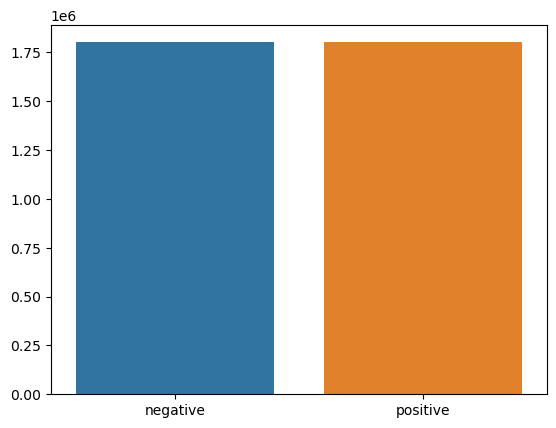

In [8]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [9]:
def create_dataframes(sentences, labels):
    # Create DataFrame for sentences
    df_sentences = pd.DataFrame({'review': sentences})
    df_sentences = df_sentences['review'].values
    # Create DataFrame for labels
    df_labels = pd.DataFrame({'sentiment': labels})
    df_labels = df_labels['sentiment'].values
    return df_sentences, df_labels

In [10]:
x_train, y_train = create_dataframes(x_train, y_train)
x_test, y_test = create_dataframes(x_test, y_test)

### Tockenization

In [11]:
import nltk
nltk.download('stopwords')
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label == '____2' else 0 for label in y_train]
    encoded_test = [1 if label =='____2' else 0 for label in y_val]
    return np.array(final_list_train, dtype="object"), np.array(encoded_train, dtype="object"),np.array(final_list_test, dtype="object"), np.array(encoded_test, dtype="object"),onehot_dict


[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [13]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

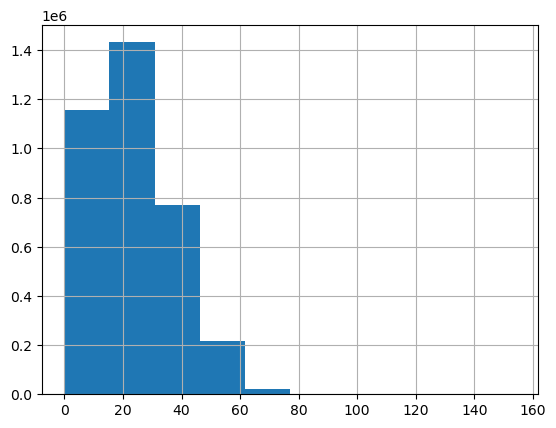

count    3.600000e+06
mean     2.387436e+01
std      1.302834e+01
min      0.000000e+00
25%      1.300000e+01
50%      2.100000e+01
75%      3.200000e+01
max      1.540000e+02
dtype: float64

In [14]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Observations : <br>a) Mean review length = around 25.<br> b) minimum length of reviews is 4.<br>c)There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis.

### Padding

Now we will pad each of the sequence to max length

In [16]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [17]:
#we have maximum length of review as 70.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,70)
x_test_pad = padding_(x_test,70)


In [23]:
x_valid_pad = x_train_pad[2800000:]
y_valid = y_train[2800000:]
x_train_pad = x_train_pad[:2800000]
y_train = y_train[:2800000]
print(f'shape of validation data is {len(x_valid)}')


shape of validation data is 800000


In [26]:
x_valid_pad = np.vstack(x_valid_pad).astype(np.float32)
y_valid = np.vstack(y_valid).astype(np.float32)
x_train_pad = np.vstack(x_train_pad).astype(np.float32)
y_train = np.vstack(y_train).astype(np.float32)
x_test_pad = np.vstack(x_test_pad).astype(np.float32)
y_test = np.vstack(y_test).astype(np.float32)

### Batching and loading as tensor

In [50]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_valid_pad), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

In [76]:
# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [77]:
# obtain one batch of training data
dataiter = iter(train_loader)

sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([32, 70])
Sample input: 
 tensor([[  0.,   0.,   0.,  ...,   8.,   5., 599.],
        [  0.,   0.,   0.,  ...,  31., 172., 383.],
        [  0.,   0.,   0.,  ..., 941.,   7.,  40.],
        ...,
        [  0.,   0.,   0.,  ..., 122.,  61.,  18.],
        [  0.,   0.,   0.,  ..., 332., 246., 192.],
        [  0.,   0.,   0.,  ...,   1.,  27., 634.]])
Sample input: 
 tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### Model

In [72]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden



In [84]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [74]:
# Checkpoint for early stopping
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

early_stop_thresh = 5
best_accuracy = np.Inf
best_epoch = -1
    
# loss and optimization functions
lr=0.0001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [78]:
clip = 5
epochs = 100

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device).long(), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float().view(-1))
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()



    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device).long(), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float().view(-1))

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        
    if epoch_val_loss <= best_accuracy:
        best_accuracy = epoch_val_loss
        best_epoch = epoch
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_accuracy,epoch_val_loss))

        checkpoint(model, "./working/best_model.pth")
        
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
    
    print(25*'==')
resume(model, "./working/best_model.pth")

Epoch 1
train_loss : 0.3080118830979296 val_loss : 0.2738358277203143
train_accuracy : 86.60575 val_accuracy : 88.414625
Validation loss decreased (0.273836 --> 0.273836).  Saving model ...
Epoch 2
train_loss : 0.26730882007437096 val_loss : 0.2575510782779753
train_accuracy : 88.68724999999999 val_accuracy : 89.240375
Validation loss decreased (0.257551 --> 0.257551).  Saving model ...
Epoch 3
train_loss : 0.24998858077922037 val_loss : 0.2453060815050453
train_accuracy : 89.52160714285714 val_accuracy : 89.77725
Validation loss decreased (0.245306 --> 0.245306).  Saving model ...
Epoch 4
train_loss : 0.2378773908357961 val_loss : 0.24036715169794856
train_accuracy : 90.09142857142857 val_accuracy : 89.957875
Validation loss decreased (0.240367 --> 0.240367).  Saving model ...
Epoch 5
train_loss : 0.22824338053473406 val_loss : 0.23706188301309944
train_accuracy : 90.55871428571429 val_accuracy : 90.166875
Validation loss decreased (0.237062 --> 0.237062).  Saving model ...
Epoch 6
tr

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

In [79]:
resume(model, "./working/best_model.pth")

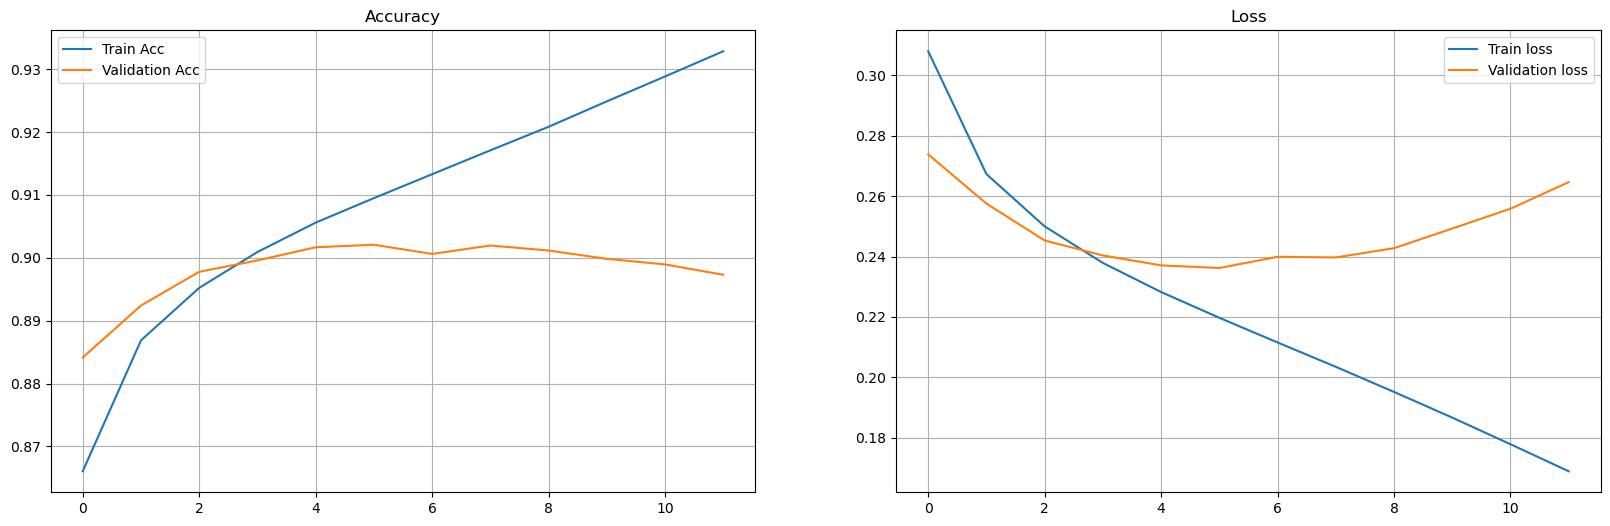

In [80]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Test Dataset

In [88]:
# Load model
model.load_state_dict(torch.load("./working/best_model.pth"))
model.eval()

test_h = model.init_hidden(batch_size)
test_losses = []
test_acc = 0.0

for inputs, labels in test_loader:
        test_h = tuple([each.data for each in test_h])

        inputs, labels = inputs.to(device).long(), labels.to(device)

        output, test_h = model(inputs, test_h)
        test_loss = criterion(output.squeeze(), labels.float().view(-1))

        test_losses.append(test_loss.item())

        accuracy = acc(output,labels)
        test_acc += accuracy

epoch_test_loss = np.mean(test_losses)
epoch_test_acc = test_acc/len(test_loader.dataset)
print(f'test_loss : {epoch_test_loss}')
print(f'test_accuracy : {epoch_test_acc*100}')

test_loss : 0.23910320262402296
test_accuracy : 90.045


### Inferance

In [100]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [95]:
y_test_inference, x_test_inference = load_fasttext_data(file_path + "test.ft.txt")

In [101]:
df = pd.DataFrame({'review': x_test_inference, 'sentiment': y_test_inference})
# Mapping dictionary
sentiment_mapping = {
    '____2': 'positive',
    '____1': 'negative',
}

# Replace values based on mapping
df['sentiment'] = df['sentiment'].replace(sentiment_mapping)

df.head()

,review,sentiment
0,Great CD: My lovely Pat has one of the GREAT v...,positive
1,One of the best game music soundtracks - for a...,positive
2,Batteries died within a year ...: I bought thi...,negative
3,"works fine, but Maha Energy is better: Check o...",positive
4,Great for the non-audiophile: Reviewed quite a...,positive


In [102]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

This is the all time best book!: This is the all time best book. She mentoins in the book how anyone can be a vampire, who knows. Well anyway I like the idea of having one soulmate and one crazed werewolf crush. P.S I think that it is a good twist on the story about how anone can be part of the night world.
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9783219695091248


In [103]:

index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

Tha BOMB of a book!!: L.J. Smith is the best author in the whole world. I read this book a year ago but I can't stop reading it. It is beyond sweet. I love Ash.The entire Night World seris is the bomb. I read mostly everyone of L.J Smiths book and they all are awesome. I think Ash and Mary Lynetee are one of the sweetest soulmates. I loved how they tried to fight there feelings but couldn't. There should be real guys like Ash,Quinn,Juliun,Damon,Gabriel and I can go on forever. I think everyone should read at least one L.J Smith book. If you do you'll be hooked on them for life,like I am. L.J Smith is the BEST!!!!
Actual sentiment is  : positive
predicted sentiment is positive with a probability of 0.9930481910705566
